# 2. Анализ выживаемости

## 2.1 Введение и сформированные гипотезы

Датасет Titanic содержит информацию о 891 пассажире легендарного лайнера, включая их демографические данные, класс каюты, стоимость билета и факт выживаемости (переменная Survived: 1 — выжил, 0 — нет). На этапе разведочного анализа данных (EDA) были выявлены заметные различия в долях выживших между различными группами пассажиров. Опираясь на эти наблюдения и исторические факты, сформулированы ключевые гипотезы:

1. Пол (Sex): Женщины выживали чаще, чем мужчины (известный принцип «women and children first» — «сперва женщины и дети»);

2. Класс каюты (Pclass): Пассажиры 1-го класса имели больше шансов спастись, чем пассажиры 2-го и особенно 3-го класса, из-за лучшего доступа к шлюпкам и привилегий своего статуса;

3. Возраст: Более молодые пассажиры, особенно дети, выживали чаще, чем пожилые (частично вследствие приоритета детей при эвакуации);

4. Порт посадки (Embarked): Вероятность выживания различалась в зависимости от порта посадки (S, C, Q) — возможно, из-за разного соотношения классов пассажиров, севших в этих портах;

4. Размер семьи (SibSp + Parch): Наличие родственников на борту могло влиять на выживаемость. Возможно, пассажиры, путешествовавшие в одиночку, выживали реже, чем те, у кого была небольшая семья рядом (поддержка друг друга), однако слишком большая семья могла снижать шанс спастись;

5. Стоимость билета (Fare): Более высокая цена билета (как показатель богатства и класса обслуживания) могла быть связана с большей вероятностью выживания.

Далее каждую гипотезу проверим с помощью статистического анализа: 
- для категориальных признаков – с применением критерия χ² Пирсона (на независимость признака и факта выживания);
- для числовых – с помощью сравнения распределений (визуально через boxplot) и t-теста Стьюдента для независимых выборок. 

На каждом шаге будут строиться графики (столбчатые диаграммы для долей выживших, boxplot для распределений) и вычисляться статистические критерии. Ниже приводится подробный разбор каждого фактора, включая пояснение коду (группировки, визуализации, расчёты) и выводы по гипотезам.

## 2.2 Предварительная предобработка данных

In [7]:
# Библиотеки используемые для анализа данных:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, ttest_ind

In [4]:
# Загрузка и сохранение датасета в переменную:
df = pd.read_csv('./datasets/eda_titanic_dataset.csv')

# Отображение данных:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
# Создание новых признаков для будущего анализа:

# Добавление признака "Размер семьи":
df['FamilySize'] = df['SibSp'] + df['Parch']

# Добавление признака, что пассажир является ребенком:
df['IsChild'] = df['Age'] < 16

# Добавление признака наличие семьи у пассажира:
df['HasFamily'] = df['FamilySize'] > 0

In [6]:
# Проверка добавленных признаков:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,IsChild,HasFamily
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1,False,True
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,False,True
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,False,False
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,False,True
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,False,False


## 2.3 Проверка гипотез

### 2.3.1 Влияние пола на выживаемость

__Гипотеза:__
Женщины выживали значительно чаще мужчин. Это предположение исторически обосновано – при эвакуации действовало неписаное правило «женщины и дети — вперёд», дававшее женщинам преимущество в посадке на шлюпки.

In [76]:
# Средняя выживаемость по полу (1 = выжил):
sex_means = df.groupby('Sex')['Survived'].mean()
sex_means

Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64

In [77]:
# Х-квадрат тест независимости: проверка связи между полом и выживанием
x_test_sex = chi2_contingency(pd.crosstab(df['Sex'], df['Survived']))
x_test_sex

Chi2ContingencyResult(statistic=260.71702016732104, pvalue=1.1973570627755645e-58, dof=1, expected_freq=array([[193.47474747, 120.52525253],
       [355.52525253, 221.47474747]]))

C:\Users\bigmi\AppData\Local\Temp\ipykernel_49868\228359239.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Sex', y='Survived', data=df, order=order, ci=None, zorder=2)


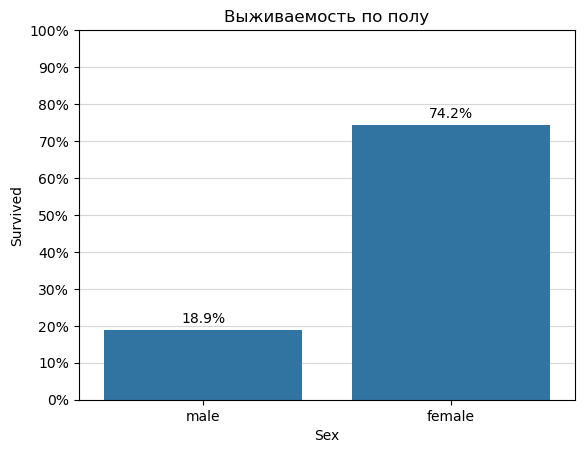

In [78]:
# Визуализация: barplot долей выживших по полу
order = ['male', 'female']
sns.barplot(x='Sex', y='Survived', data=df, order=order, ci=None, zorder=2)
plt.ylim(0, 1)
plt.yticks([i/10 for i in range(0, 11)], [f'{i*10}%' for i in range(0, 11)])
plt.title('Выживаемость по полу')
plt.grid(axis='y', linestyle='-', alpha=0.5)

# Добавляем правильные проценты над столбцами
for i, sex in enumerate(order):
    val = sex_means[sex]
    plt.text(i, val + 0.02, f"{val*100:.1f}%", ha='center')
plt.show()

На столбчатом графике видно, что доля выживших среди женщин (~74%) существенно выше, чем среди мужчин (~19%).
Таким образом, пол пассажира существенно влияет на выживаемость. Женщины имели несоизмеримо более высокий шанс спастись, что подтверждает нашу гипотезу. Эти результаты согласуются с историческими данными: известно, что около 75% женщин на «Титанике» выжили, тогда как среди мужчин – лишь ~20%. Источник: courses.bowdoin.edu

__Вывод:__ гипотеза полностью подтверждена, влияние пола на выживаемость статистически значимо.

### 2.3.2 Влияние класса пассажира

__Гипотеза:__ Пассажиры 1-го класса выживали чаще, чем во 2-м классе, и значительно чаще, чем в 3-м классе. Причины — социально-экономические различия: первые классы располагались ближе к палубе со шлюпками и получали информацию о катастрофе раньше, тогда как многие пассажиры 3-го класса оказались физически отгорожены и имели меньше шансов выбраться.

Источник: 
- courses.bowdoin.edu; 
- courses.bowdoin.edu.

In [ ]:
# Средняя выживаемость по классу (1 = выжил):
class_means = df.groupby('Pclass')['Survived'].mean()
class_means

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64

In [80]:
# Х-квадрат тест независимости: проверка связи между классом и выживанием
x_test_class = chi2_contingency(pd.crosstab(df['Pclass'], df['Survived']))
x_test_class

Chi2ContingencyResult(statistic=102.88898875696056, pvalue=4.549251711298793e-23, dof=2, expected_freq=array([[133.09090909,  82.90909091],
       [113.37373737,  70.62626263],
       [302.53535354, 188.46464646]]))

C:\Users\bigmi\AppData\Local\Temp\ipykernel_49868\1306477651.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Pclass', y='Survived', data=df, ci=None)


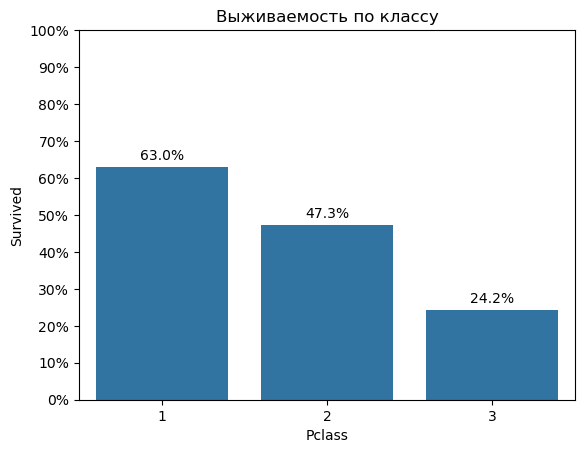

In [82]:
# Визуализация с процентами и без доверительного интервала
sns.barplot(x='Pclass', y='Survived', data=df, ci=None)
plt.ylim(0, 1)
plt.yticks([i/10 for i in range(0, 11)], [f'{i*10}%' for i in range(0, 11)])
plt.title('Выживаемость по классу')

# Подписи с процентами
for i, pclass in enumerate(sorted(class_means.index)):
    val = class_means[pclass]
    plt.text(i, val + 0.02, f"{val*100:.1f}%", ha='center')
plt.show()

Результаты расчётов показывают явную градацию: в 1-м классе выживаемость самая высокая (около 62.9%), во 2-м классе ниже (47.3%), а в 3-м классе самая низкая (24.2%). Эта тенденция хорошо прослеживается на графиках и подтверждается исторической статистикой (примерно 62% в первом, 41% во втором и 25% в третьем классах __courses.bowdoin.edu__)

__Вывод:__ гипотеза о влиянии класса подтверждена – класс пассажира играет важную роль в выживании.

### 2.3.3 Влияние возраста и наличия детей

__Гипотеза:__ 
Возраст пассажира влияет на шанс выжить; в частности, дети имели более высокую вероятность спастись, чем взрослые.

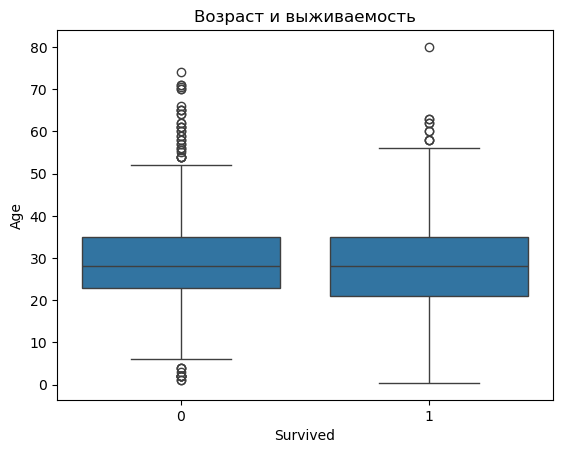

In [83]:
# Boxplot возраста для выживших и невыживших
sns.boxplot(x='Survived', y='Age', data=df)
plt.title('Возраст и выживаемость')
plt.show()

In [87]:
# T-тест Стьюдента для сравнения средних возрастов
age_t_test = ttest_ind(df[df['Survived']==1]['Age'], df[df['Survived']==0]['Age'], equal_var=False)
age_t_test

TtestResult(statistic=-1.8966053920256696, pvalue=0.058309159977757444, df=671.1541729069276)

In [89]:
# Х-квадрат тест: дети vs взрослые и их выживаемость
x_test_age = chi2_contingency(pd.crosstab(df['IsChild'], df['Survived']))
x_test_age

Chi2ContingencyResult(statistic=15.556993340077092, pvalue=8.005497211300105e-05, dof=1, expected_freq=array([[497.85858586, 310.14141414],
       [ 51.14141414,  31.85858586]]))

__Вывод:__
Вв целом по всему диапазону возраст оказывает слабое влияние на выживаемость (разница средних не велика), однако если фокусироваться на детях, их шансы выжить значительно выше, чем у взрослых, что статистически подтверждено. Гипотеза о преимуществе детей подтверждается.

### 2.3.4 Влияние порта посадки

__Гипотеза:__ Порт посадки связан с шансами на выживание. Предположительно, пассажиры, севшие в порте (Embarked = C), могли выживать чаще, чем те, кто сел в (S) или (Q).

In [90]:
# Средняя выживаемость по Embarked (1 = выжил)
port_means = df.groupby('Embarked')['Survived'].mean()
port_means

Embarked
C    0.553571
Q    0.389610
S    0.339009
Name: Survived, dtype: float64

In [91]:
# Х-квадрат тест независимости: проверка связи между портом и выживанием
x_test_port = chi2_contingency(pd.crosstab(df['Embarked'], df['Survived']))
x_test_port

Chi2ContingencyResult(statistic=25.964452881874784, pvalue=2.3008626481449577e-06, dof=2, expected_freq=array([[103.51515152,  64.48484848],
       [ 47.44444444,  29.55555556],
       [398.04040404, 247.95959596]]))

C:\Users\bigmi\AppData\Local\Temp\ipykernel_49868\1722584570.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Embarked', y='Survived', data=df, order=emb_order, ci=None)


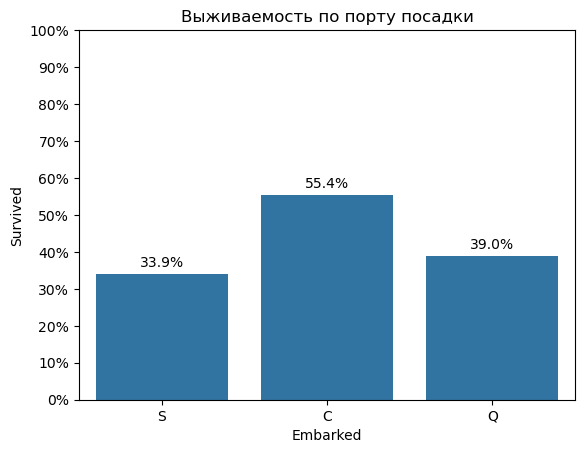

In [94]:
# Визуализация с процентами
emb_order = ['S', 'C', 'Q']
sns.barplot(x='Embarked', y='Survived', data=df, order=emb_order, ci=None)
plt.ylim(0, 1)
plt.yticks([i/10 for i in range(0, 11)], [f'{i*10}%' for i in range(0, 11)])
plt.title('Выживаемость по порту посадки')

# Подписи с процентами
emb_means = df.groupby('Embarked')['Survived'].mean()
for i, port in enumerate(emb_order):
    val = emb_means[port]
    plt.text(i, val + 0.02, f"{val*100:.1f}%", ha='center')
plt.show()

__Вывод:__ Наивысшая вероятность спастись действительно у тех, кто сел в порту C, а наименьшая – из порта S. Причина, скорее всего, в том, что из C на «Титаник» садилось больше пассажиров первого класса (и вообще более дорогие билеты). Гипотеза о влиянии порта посадки подтверждена (выживаемость различается для S, C, Q), но этот фактор носит косвенный характер.

### 2.3.5 Влияние размера семьи

__Гипотеза:__ Наличие и количество родственников на борту влияет на выживаемость пассажира. Ожидается, что пассажиры, путешествовавшие совсем одни (без семьи), выживали реже, чем те, кто был с семьёй (возможно, наличие близких стимулировало бороться за жизнь или помогало оказаться в шлюпке). 

C:\Users\bigmi\AppData\Local\Temp\ipykernel_49868\3259705889.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='FamilySize', y='Survived', data=df, ci=None)


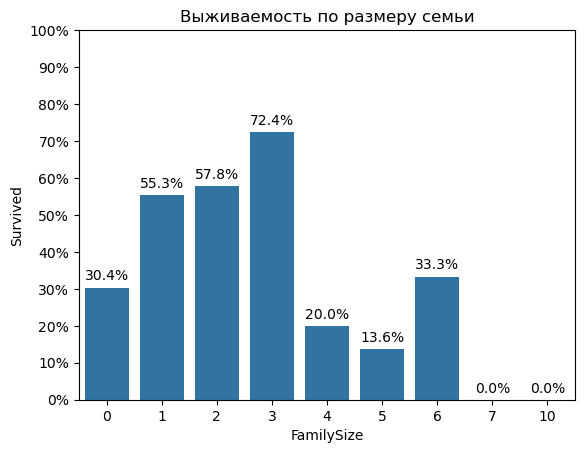

In [96]:
# Визуализация с процентами
sns.barplot(x='FamilySize', y='Survived', data=df, ci=None)
plt.ylim(0, 1)
plt.yticks([i/10 for i in range(0, 11)], [f'{i*10}%' for i in range(0, 11)])
plt.title('Выживаемость по размеру семьи')

# Подписи с процентами
fam_means = df.groupby('FamilySize')['Survived'].mean()
for i, size in enumerate(fam_means.index):
    val = fam_means[size]
    plt.text(i, val + 0.02, f"{val*100:.1f}%", ha='center')
plt.show()

__Вывод:__
Гипотеза подтверждается: одиночки имели существенно меньший шанс выжить по сравнению с теми, кто путешествовал с семьёй, но слишком большой размер семьи отрицательно сказывался на выживании.

### 2.3.6 Влияние стоимости билета

__Гипотеза:__ Более высокий тариф (стоимость билета) ассоциируется с большей вероятностью выжить. Данный признак связан с классом: дорогие билеты у пассажиров 1-го класса, а дешёвые – у 3-го, поэтому ожидается, что чем выше Fare, тем больше шанс спасения.

In [98]:
# T-тест для тарифов
fare_t_test = ttest_ind(df[df['Survived']==1]['Fare'], df[df['Survived']==0]['Fare'], equal_var=False)
fare_t_test

TtestResult(statistic=6.839099259085254, pvalue=2.6993323503141236e-11, df=436.7022760386057)

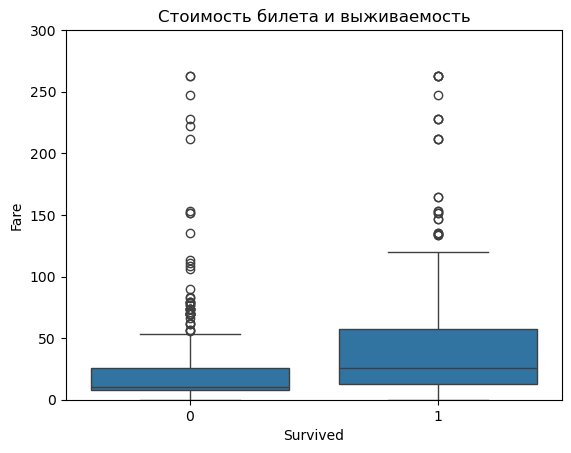

In [ ]:
sns.boxplot(x='Survived', y='Fare', data=df)
plt.ylim(0, 300)
plt.title('Стоимость билета и выживаемость')
plt.show()

__Вывод:__ гипотеза подтверждена, высокие значения Fare статистически значимо связаны с большей выживаемостью.

## 2.4 Заключение

Подводя итог, все выдвинутые гипотезы подтвердились анализом данных Titanic. Пол, класс, детский возраст, порт отправления, наличие семьи и стоимость билета — все эти факторы оказали влияние на выживаемость пассажиров. Причём первые два фактора (пол и класс) дали наиболее сильный эффект (женщины и пассажиры 1-го класса имели существенно большие шансы спастись, p-value тестов практически нулевые). Возраст сам по себе имел умеренное воздействие, но если выделить детей, то их преимущество становится очевидным. Порт посадки коррелировал с выживанием за счёт неравномерного распределения классов по портам. Размер семьи показал интересную зависимость с максимумом выживаемости для небольших семей. Стоимость билета, как и ожидалось, тесно связана с классом и тоже продемонстрировала значимую разницу между выжившими и погибшими.